In [1]:
!pip install ipywidgets > /dev/null

In [ ]:
!pip install matplotlib > /dev/null
!pip install scikit-learn > /dev/null

In [ ]:
!pip install joblib > /dev/null

In [ ]:
!pip install category_encoders

In [ ]:
!pip install --upgrade catboost

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt

from numpy import mean

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, train_test_split, cross_val_score, cross_validate

from sklearn.metrics import precision_recall_curve, balanced_accuracy_score, precision_score, accuracy_score, recall_score, classification_report, PrecisionRecallDisplay, make_scorer, f1_score, average_precision_score
from sklearn.preprocessing import RobustScaler,OneHotEncoder

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import random
from sklearn.impute import SimpleImputer

import shap
from lime import lime_tabular
from category_encoders import CatBoostEncoder


In [3]:
identity     = pd.read_csv('teste1/train_identity.csv', usecols=['TransactionID', 'DeviceType', 'DeviceInfo'])
transactions = pd.read_csv('teste2/train_transaction.csv', usecols=['TransactionID','TransactionAmt', 'ProductCD', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'isFraud'])

df = pd.merge(transactions, identity, on="TransactionID", how="left")
df = df.drop('TransactionID', axis=1)

df.head()

,isFraud,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,M1,M2,M3,M4,M5,M6,M7,M8,M9,DeviceType,DeviceInfo
0,0,68.5,W,13926,NaN,150.0,discover,142.0,credit,T,T,T,M2,F,T,NaN,NaN,NaN,NaN,NaN
1,0,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN,NaN,NaN
2,0,59.0,W,4663,490.0,150.0,visa,166.0,debit,T,T,T,M0,F,F,F,F,F,NaN,NaN
3,0,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,NaN,NaN,NaN,M0,T,F,NaN,NaN,NaN,NaN,NaN
4,0,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,mobile,SAMSUNG SM-G892A Build/NRD90M


In [4]:
classe     = df['isFraud']      
product_cd = df['ProductCD'] 
card4      = df['card4']      
card6      = df['card6']      
deviceType = df['DeviceType'] 
deviceInfo = df['DeviceInfo']
m1         = df['M1']
m2         = df['M2']
m3         = df['M3']
m4         = df['M4']
m5         = df['M5']
m6         = df['M6']
m7         = df['M7']
m8         = df['M8']
m9         = df['M9']
ta         = df['TransactionAmt']

df.drop(['isFraud', 'ProductCD', 'card4', 'card6', 'TransactionAmt', 'DeviceType', 'DeviceInfo', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9'], axis=1, inplace=True)
df.insert(0, 'Class', classe)
df.insert(1, 'PCD', product_cd)
df.insert(2, 'card4', card4)
df.insert(3, 'card6', card6)
df.insert(4, 'DT', deviceType)
df.insert(5, 'DI', deviceInfo)
df.insert(6, 'M1', m1)
df.insert(7, 'M2', m2)
df.insert(8, 'M3', m3)
df.insert(9, 'M4', m4)
df.insert(10, 'M5', m5)
df.insert(11, 'M6', m6)
df.insert(12, 'M7', m7)
df.insert(13, 'M8', m8)
df.insert(14, 'M9', m9)
df.insert(15, 'TA', ta)

df.head()

,Class,PCD,card4,card6,DT,DI,M1,M2,M3,M4,M5,M6,M7,M8,M9,TA,card1,card2,card3,card5
0,0,W,discover,credit,NaN,NaN,T,T,T,M2,F,T,NaN,NaN,NaN,68.5,13926,NaN,150.0,142.0
1,0,W,mastercard,credit,NaN,NaN,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN,29.0,2755,404.0,150.0,102.0
2,0,W,visa,debit,NaN,NaN,T,T,T,M0,F,F,F,F,F,59.0,4663,490.0,150.0,166.0
3,0,W,mastercard,debit,NaN,NaN,NaN,NaN,NaN,M0,T,F,NaN,NaN,NaN,50.0,18132,567.0,150.0,117.0
4,0,H,mastercard,credit,mobile,SAMSUNG SM-G892A Build/NRD90M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,4497,514.0,150.0,102.0


In [5]:
X = df.drop('Class', axis=1)
y = df['Class']

In [6]:
fraud_percent      = df['Class'].value_counts()[0] / len(df) * 100
not_fraud_percent = df['Class'].value_counts()[1] / len(df) * 100

print("Porcentagem de transações fraudulentas %.2f"%fraud_percent)
print("Porcentagem de transações não fraudulentas %.2f"%not_fraud_percent)

Porcentagem de transações fraudulentas 96.50
Porcentagem de transações não fraudulentas 3.50


In [7]:
data_dict = {
    'logistic_regression_values': [],
    'logistic_regression_lime': [], 
    'logistic_regression_shap': [],
    'random_forest_lime': [],
    'random_forest_shap': [],
    'svm_lime': [],
    'svm_shap': [],
    'mlp_classifier_lime': [],
    'mlp_classifier_shap': [],
    'decision_tree_lime': [],
    'decision_tree_shap': []
}

def save_model_data(model, data, method):
    if isinstance(model, LogisticRegression):
        if method == 'lime': 
            data_dict['logistic_regression_lime'].append(data)
        else:
            if method == 'shap':
                data_dict['logistic_regression_shap'].append(data)
            else:
                data_dict['logistic_regression_values'].append(data)
    elif isinstance(model, RandomForestClassifier):
        if method == 'lime': 
            data_dict['random_forest_lime'].append(data)
        else:
            data_dict['random_forest_shap'].append(data)
    elif isinstance(model, LinearSVC):
        if method == 'lime': 
            data_dict['svm_lime'].append(data)
        else:
            data_dict['svm_shap'].append(data)
    elif isinstance(model, MLPClassifier):
        if method == 'lime': 
            data_dict['mlp_classifier_lime'].append(data)
        else:
            data_dict['mlp_classifier_shap'].append(data)
    elif isinstance(model, DecisionTreeClassifier):
        if method == 'lime': 
            data_dict['decision_tree_lime'].append(data)
        else:
            data_dict['decision_tree_shap'].append(data)
    else:
        print("Unrecognized model type")

In [8]:
default_pos_color = "#008bfb"

In [9]:
def normal_train (model_algorithm, X, y, shap_type='', pred=False):

    shap_explainers    = []
    lime_explainers    = []
    models             = []
    samples            = []
    
    precision_scores   = []
    f1_scores          = []
    balanced_acuracies = []
    sensitivity_scores = []
    specificity_scores = []
    auprc_scores       = []
    
    
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)
    
    for train_index, test_index in cv.split(X, y):
        
        if model_algorithm == 0:
            model = LogisticRegression(max_iter=2000, solver='newton-cholesky', random_state=1)
        elif model_algorithm == 1:
            model = DecisionTreeClassifier(random_state=1)
        elif model_algorithm == 2:
            model = RandomForestClassifier(max_depth=2, random_state=1)
        elif model_algorithm == 3:
            model = LinearSVC(max_iter=2000, dual=False, random_state=1)
        else:
            model =  MLPClassifier(random_state=1)
            
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        X_train = X_train.copy()
        X_test  = X_test.copy()
        
        numeric_cols = ['TA', 'card1', 'card2', 'card3', 'card5']
        numeric_imputer = SimpleImputer(strategy='median')
        X_train.loc[:, numeric_cols] = numeric_imputer.fit_transform(X_train[numeric_cols])
        X_test.loc[:, numeric_cols] = numeric_imputer.transform(X_test[numeric_cols])

        categorical_cols = ['PCD', 'M1', 'M2', 'M3', 'M4', 'card4', 'card6', 'DT', 'DI', 'M5', 'M6', 'M7', 'M8', 'M9']
        categorical_imputer = SimpleImputer(strategy='most_frequent')
        X_train.loc[:, categorical_cols] = categorical_imputer.fit_transform(X_train[categorical_cols])
        X_test.loc[:, categorical_cols] = categorical_imputer.transform(X_test[categorical_cols])

        encoder = CatBoostEncoder(random_state=1)
        encoded_cols = encoder.fit_transform(X_train.loc[:, categorical_cols], y_train)
        X_train = pd.concat([X_train.drop(columns=categorical_cols), encoded_cols], axis=1)
        encoded_cols = encoder.transform(X_test.loc[:, categorical_cols], y_test)
        X_test = pd.concat([X_test.drop(columns=categorical_cols), encoded_cols], axis=1)
        
        oversample = SMOTE(random_state=1)
        X_train_smote, y_train_smote = oversample.fit_resample(X_train, y_train)

        positive_samples_index = np.where(y_train == 1)[0]
        random_positive_sample_index = np.random.choice(positive_samples_index)
        random_positive_sample = X_train.iloc[random_positive_sample_index]
        samples.append(random_positive_sample)
        
        model.fit(X_train_smote, y_train_smote)
        models.append(model)
        
        #SHAP Stuff
        shapexplainer = shap.Explainer(model.predict, X_train_smote, seed=1)   
        shap_explainers.append(shapexplainer)

        #LIME Stuff
        lime_explainer = lime_tabular.LimeTabularExplainer(
            training_data=np.array(X_train_smote),
            feature_names=X_train_smote.columns,
            class_names=['legítima', 'fraude'],
            mode='classification',
            random_state=1
        )
        
        lime_explainers.append(lime_explainer)
        
        y_pred = model.predict(X_test)
        
        balanced_acuracies.append(balanced_accuracy_score(y_test, y_pred))
        sensitivity_scores.append(recall_score(y_test, y_pred))
        specificity_scores.append(recall_score(y_test, y_pred, pos_label=0))
        precision_scores.append(precision_score(y_test, y_pred))
        f1_scores.append(f1_score(y_test, y_pred))
        auprc_scores.append(average_precision_score(y_test, y_pred))
     
    
    return {
        'shap_explainers'    : shap_explainers,
        'lime_explainers'    : lime_explainers,
        'models'             : models,
        'samples'            : samples,
        'sensitivity_scores' : sensitivity_scores,
        'balanced_acuracies' : balanced_acuracies,
        'specificity_scores' : specificity_scores,
        'precision_scores'   : precision_scores,
        'f1_scores'          : f1_scores,
        'auprc_scores'       : auprc_scores
    }




In [10]:
def plot_results_logistic_regression_to_file(training_results):

    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 3), sharey=False)
    fig.tight_layout(pad=3.2)

    for i in range (0, 5):
        
        fraud_sample = training_results['samples'][i]
        
        model = training_results['models'][i]
        avg_model_coeficients = np.mean(abs(model.coef_), axis=0)
        top_indices = np.argsort(avg_model_coeficients)[::-1][:10]

        bars = axes[i].barh(np.arange(10), np.flip(avg_model_coeficients[top_indices]), align='center', color=default_pos_color)

        for j, bar in enumerate(bars):
            axes[i].text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2., \
                    '{:.3f}'.format(np.flip(avg_model_coeficients[top_indices])[j]), \
                    ha='left', va='center', color=default_pos_color)
        
        #axes[i].set_xlabel('Fold {}'.format(i+1))
        axes[i].spines["right"].set_visible(False)
        axes[i].spines["top"].set_visible(False)
        axes[i].set_yticks(np.arange(10))
        axes[i].set_yticklabels(np.flip(fraud_sample.keys()[top_indices]))
        
        data = np.flip(fraud_sample.keys()[top_indices])
        save_model_data(model, data, 'reg')
    
    plt.suptitle("Regressão logística (Pesos do modelo)")
    plt.savefig("ieee_img/logistic_regression_feature_importance_plot.pdf", format="pdf")
    axes[0].set_ylabel('Nome do preditor')
    
def plot_lime_results_to_file_for_svm(training_results, plot_title, file_name):

    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 3), sharey=False)
    fig.tight_layout(pad=3.2)

    for i in range (0, 5):
        fraud_sample = training_results['samples'][i]
        
        model = training_results['models'][i]
        explainer = training_results['lime_explainers'][i]
        
        explanation = explainer.explain_instance(
            data_row=fraud_sample,
            predict_fn=model._predict_proba_lr
        )
        
        feature_names   = []
        feature_weights = []
        
        for index, tup in enumerate(explanation.as_map()[1]):
            feature_names.append(fraud_sample.keys()[tup[0]])
            feature_weights.append(abs(tup[1]))
        
        features_weights = np.array(np.abs(feature_weights)).mean(axis=0)
        top_indices = np.argsort(features_weights)[::-1][:10]
          
        bars = axes[i].barh(np.arange(10), np.flip(feature_weights), align='center', color=default_pos_color)
        
        for j, bar in enumerate(bars):
            axes[i].text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2., \
                    '{:.3f}'.format(np.flip(feature_weights)[j]), \
                    ha='left', va='center', color=default_pos_color)

        #axes[i].set_xlabel('Fold {}'.format(i+1))
        axes[i].spines["right"].set_visible(False)
        axes[i].spines["top"].set_visible(False)
        axes[i].set_yticks(np.arange(10))
        axes[i].set_yticklabels(np.flip(feature_names))
        
        save_model_data(model, np.flip(feature_names), 'lime')

    plt.suptitle(plot_title)
    plt.savefig(file_name)
    axes[0].set_ylabel('Nome do preditor')
    
def plot_lime_results_to_file(training_results, plot_title, file_name):

    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 3), sharey=False)
    fig.tight_layout(pad=3.2)

    for i in range (0, 5):
        
        fraud_sample = training_results['samples'][i]
        model = training_results['models'][i]
        explainer = training_results['lime_explainers'][i]
        
        explanation = explainer.explain_instance(
            data_row=fraud_sample,
            predict_fn=model.predict_proba
        )
        
        feature_names   = []
        feature_weights = []
        
        
        for index, tup in enumerate(explanation.as_map()[1]):
            feature_names.append(fraud_sample.keys()[tup[0]])
            feature_weights.append(abs(tup[1]))
        
        features_weights = np.array(np.abs(feature_weights)).mean(axis=0)
        top_indices = np.argsort(features_weights)[::-1][:10]
        
        
        bars = axes[i].barh(np.arange(10), np.flip(feature_weights), align='center', color=default_pos_color)
        
        for j, bar in enumerate(bars):
            le = round(np.flip(feature_weights)[j], 3)
            axes[i].text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2., \
                    '{:.3f}'.format(le), \
                    ha='left', va='center', color=default_pos_color)

        #axes[i].set_xlabel('Fold {}'.format(i+1))
        axes[i].spines["right"].set_visible(False)
        axes[i].spines["top"].set_visible(False)
        axes[i].set_yticks(np.arange(10))
        axes[i].set_yticklabels(np.flip(feature_names))
        
        save_model_data(model, np.flip(feature_names), 'lime')
    
    plt.suptitle(plot_title)
    plt.savefig(file_name)
    axes[0].set_ylabel('Nome do preditor')
    
def plot_shap_results_to_file(training_results, plot_title, file_name):

    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 3), sharey=False)
    fig.tight_layout(pad=3.2)

    for i in range (0, 5):
        
        fraud_sample = training_results['samples'][i]
        
        model = training_results['models'][i]
        explainer   = training_results['shap_explainers'][i]
        shap_values = explainer(fraud_sample.values.reshape(1,-1)).values
        
        if (shap_values.ndim == 3):
            fraud_shap_values = shap_values[0][:, 1]
            fraud_shap_values_reset = pd.Series(fraud_shap_values, index=pd.Index(fraud_sample.keys()))
            fraud_shap_values_abs = np.abs(fraud_shap_values_reset.values)
            fraud_shap_values_abs = fraud_shap_values_abs.reshape(1, -1)
            mean_shap_values = fraud_shap_values_abs.mean(axis=0)
        else:
            mean_shap_values = np.abs(shap_values).mean(axis=0)

        top_indices = np.argsort(mean_shap_values)[::-1][:10]
        
        bars = axes[i].barh(np.arange(10), np.flip(mean_shap_values[top_indices]), align='center', color=default_pos_color)

        for j, bar in enumerate(bars):
            axes[i].text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2., \
                    '{:.3f}'.format(np.flip(mean_shap_values[top_indices])[j]), \
                    ha='left', va='center', color=default_pos_color)
        
        #axes[i].set_xlabel('Fold {}'.format(i+1))
        axes[i].spines["right"].set_visible(False)
        axes[i].spines["top"].set_visible(False)
        axes[i].set_yticks(np.arange(10))
        axes[i].set_yticklabels(np.flip(    fraud_sample.keys()[top_indices]   ))
        
        data = np.flip(fraud_sample.keys()[top_indices])
        save_model_data(model, data, 'shap')
    
    plt.suptitle(plot_title)
    plt.savefig(file_name)
    axes[0].set_ylabel('Nome do preditor')

In [11]:
cross_log           = normal_train(0, X, y, pred=True)

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newval

In [12]:
print("Métricas regressão logística: \n")

print("Sensibilidade: %f\n"%np.mean(cross_log['sensitivity_scores']))
print("Acurácia balanceada: %f\n"%np.mean(cross_log['balanced_acuracies']))
print("Especificidade: %f\n"%np.mean(cross_log['specificity_scores']))
print("Precisão: %f\n"%np.mean(cross_log['precision_scores']))
print("F1: %f\n"%np.mean(cross_log['f1_scores']))
print("AUPRC: %f\n"%np.mean(cross_log['auprc_scores']))

Métricas regressão logística: 

Sensibilidade: 0.608431

Acurácia balanceada: 0.691912

Especificidade: 0.775392

Precisão: 0.089472

F1: 0.155982

AUPRC: 0.068126



In [13]:
cross_decision_tree = normal_train(1, X, y, shap_type='Tree')

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newval

In [14]:
print("Métricas árvore de decisão: \n")

print("Sensibilidade: %f\n"%np.mean(cross_decision_tree['sensitivity_scores']))
print("Acurácia balanceada: %f\n"%np.mean(cross_decision_tree['balanced_acuracies']))
print("Especificidade: %f\n"%np.mean(cross_decision_tree['specificity_scores']))
print("Precisão: %f\n"%np.mean(cross_decision_tree['precision_scores']))
print("F1: %f\n"%np.mean(cross_decision_tree['f1_scores']))
print("AUPRC: %f\n"%np.mean(cross_decision_tree['auprc_scores']))

Métricas árvore de decisão: 

Sensibilidade: 0.663072

Acurácia balanceada: 0.559915

Especificidade: 0.456758

Precisão: 0.042565

F1: 0.079929

AUPRC: 0.039979



In [15]:
cross_random_fres   = normal_train(2, X, y, shap_type='Tree')

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newval

In [16]:
print("Métricas floresta aleatória: \n")

print("Sensibilidade: %f\n"%np.mean(cross_random_fres['sensitivity_scores']))
print("Acurácia balanceada: %f\n"%np.mean(cross_random_fres['balanced_acuracies']))
print("Especificidade: %f\n"%np.mean(cross_random_fres['specificity_scores']))
print("Precisão: %f\n"%np.mean(cross_random_fres['precision_scores']))
print("F1: %f\n"%np.mean(cross_random_fres['f1_scores']))
print("AUPRC: %f\n"%np.mean(cross_random_fres['auprc_scores']))

Métricas floresta aleatória: 

Sensibilidade: 0.602190

Acurácia balanceada: 0.654470

Especificidade: 0.706751

Precisão: 0.073914

F1: 0.130505

AUPRC: 0.057644



In [17]:
cross_svm            = normal_train(3, X, y, pred=True)

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newval

In [18]:
print("Métricas SVM: \n")

print("Sensibilidade: %f\n"%np.mean(cross_svm['sensitivity_scores']))
print("Acurácia balanceada: %f\n"%np.mean(cross_svm['balanced_acuracies']))
print("Especificidade: %f\n"%np.mean(cross_svm['specificity_scores']))
print("Precisão: %f\n"%np.mean(cross_svm['precision_scores']))
print("F1: %f\n"%np.mean(cross_svm['f1_scores']))
print("AUPRC: %f\n"%np.mean(cross_svm['auprc_scores']))

Métricas SVM: 

Sensibilidade: 0.484446

Acurácia balanceada: 0.668878

Especificidade: 0.853311

Precisão: 0.108193

F1: 0.176190

AUPRC: 0.070114



In [212]:
cross_ann           = normal_train(4, X, y, pred=True)

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newval

In [218]:
print("Métricas ANN: \n")

print("Sensibilidade: %f\n"%np.mean(cross_ann['sensitivity_scores']))
print("Acurácia balanceada: %f\n"%np.mean(cross_ann['balanced_acuracies']))
print("Especificidade: %f\n"%np.mean(cross_ann['specificity_scores']))
print("Precisão: %f\n"%np.mean(cross_ann['precision_scores']))
print("F1: %f\n"%np.mean(cross_ann['f1_scores']))
print("AUPRC: %f\n"%np.mean(cross_ann['auprc_scores']))

Métricas ANN: 

Sensibilidade: 0.606832

Acurácia balanceada: 0.689626

Especificidade: 0.772421

Precisão: 0.089337

F1: 0.155307

AUPRC: 0.067634



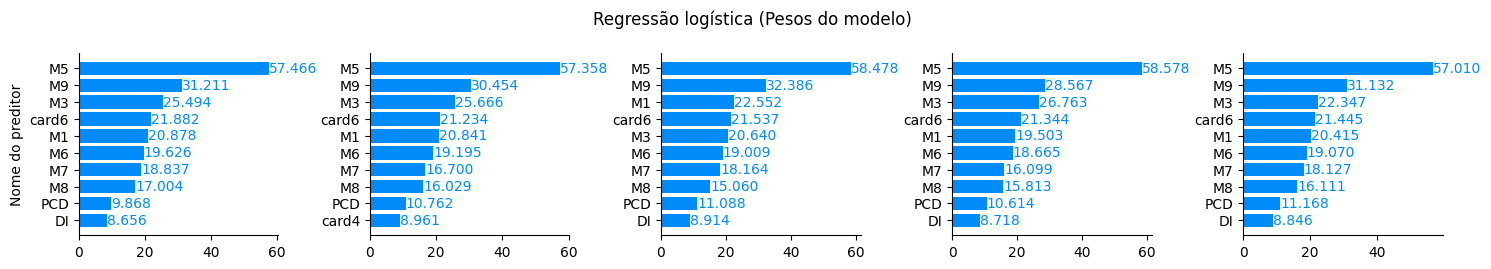

In [199]:
plot_results_logistic_regression_to_file(cross_log)

## SHAP plots

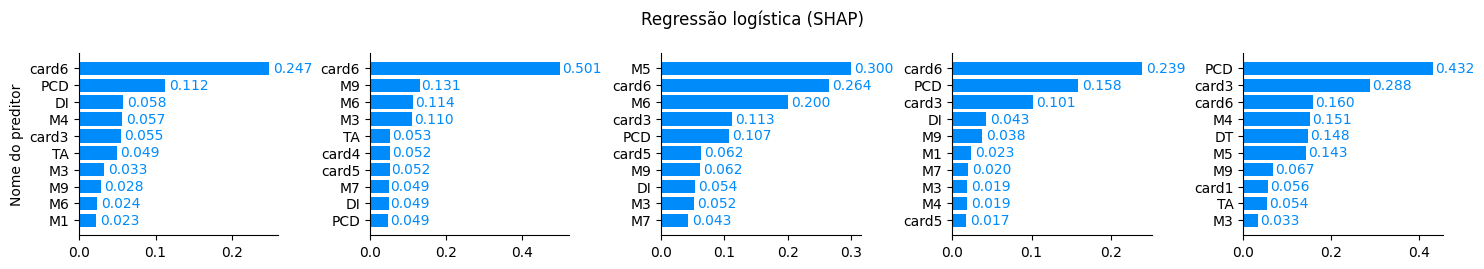

In [200]:
plot_shap_results_to_file(cross_log, "Regressão logística (SHAP)", "ieee_img/logistic_regression_feature_importance_plot(shap).pdf")

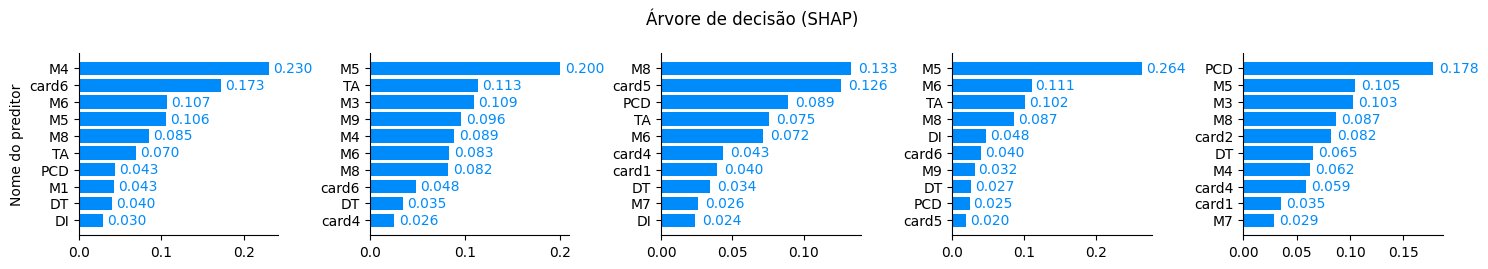

In [201]:
plot_shap_results_to_file(cross_decision_tree, "Árvore de decisão (SHAP)", "ieee_img/decision_tree_feature_importance_plot(shap).pdf")

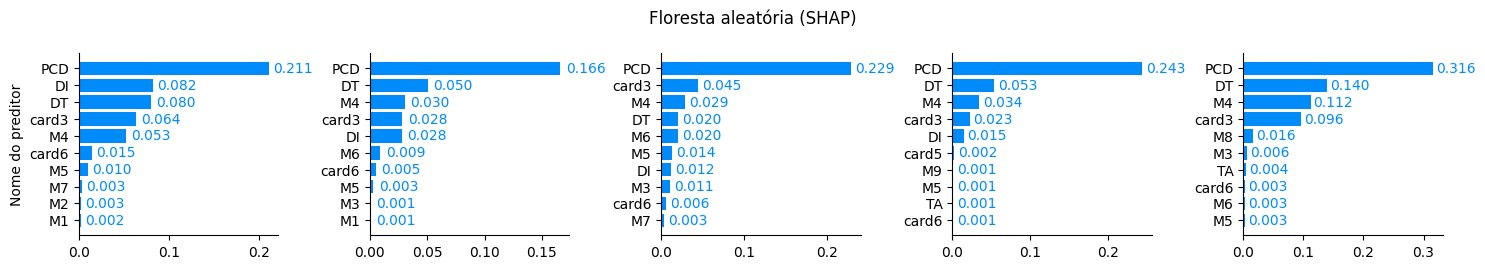

In [202]:
plot_shap_results_to_file(cross_random_fres, "Floresta aleatória (SHAP)", "ieee_img/random_forest_feature_importance_plot(shap).pdf")

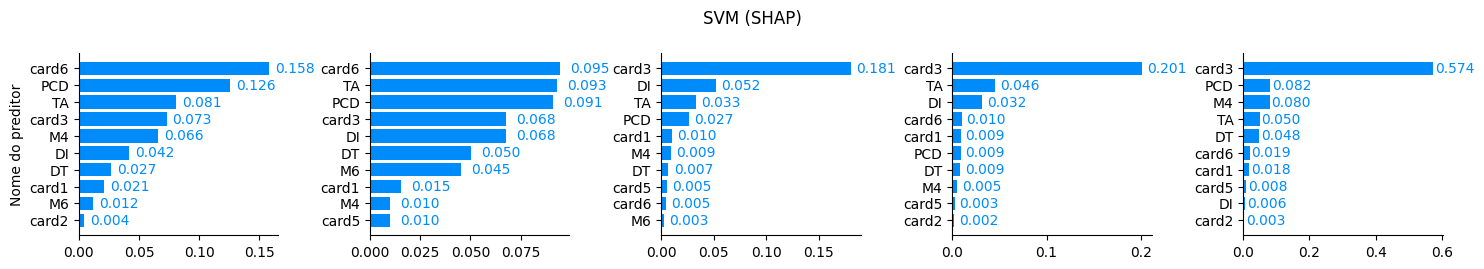

In [203]:
plot_shap_results_to_file(cross_svm, "SVM (SHAP)", "ieee_img/svm_feature_importance_plot(shap).pdf")

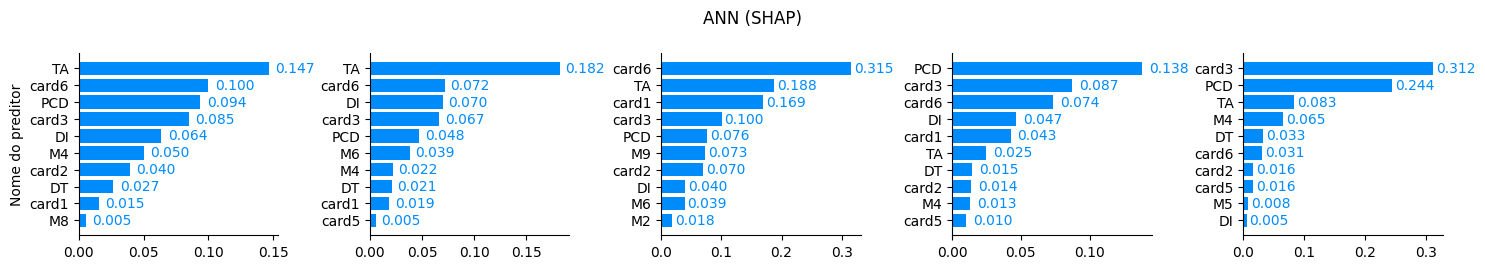

In [204]:
plot_shap_results_to_file(cross_ann, "ANN (SHAP)", "ieee_img/ann_feature_importance_plot(shap).pdf")

## LIME plots

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


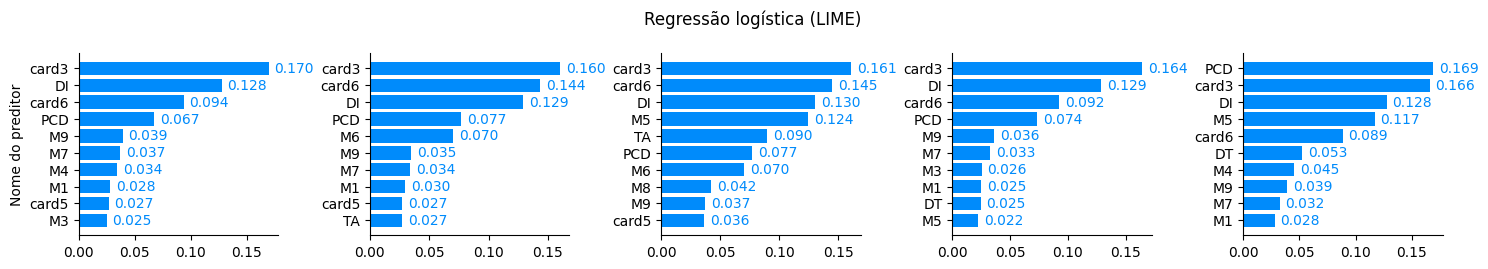

In [205]:
plot_lime_results_to_file(cross_log, "Regressão logística (LIME)", "ieee_img/logistic_regression_feature_importance_plot(lime).pdf")

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


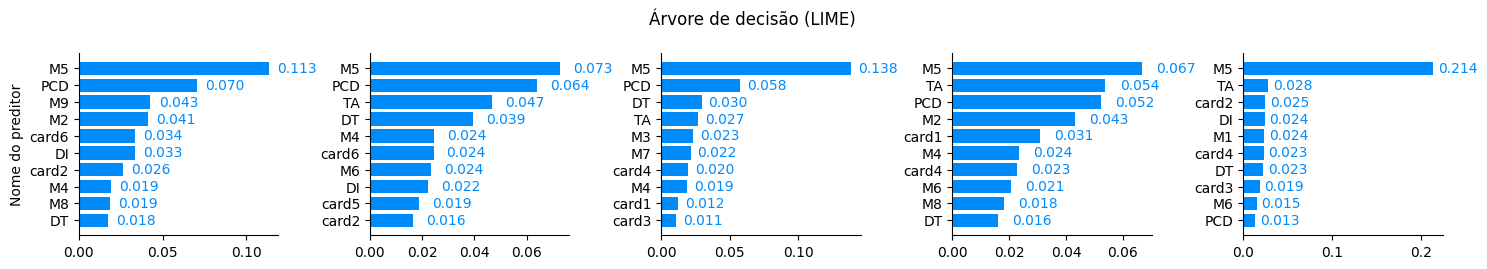

In [206]:
plot_lime_results_to_file(cross_decision_tree, "Árvore de decisão (LIME)", "ieee_img/decision_tree_feature_importance_plot(lime).pdf")

X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


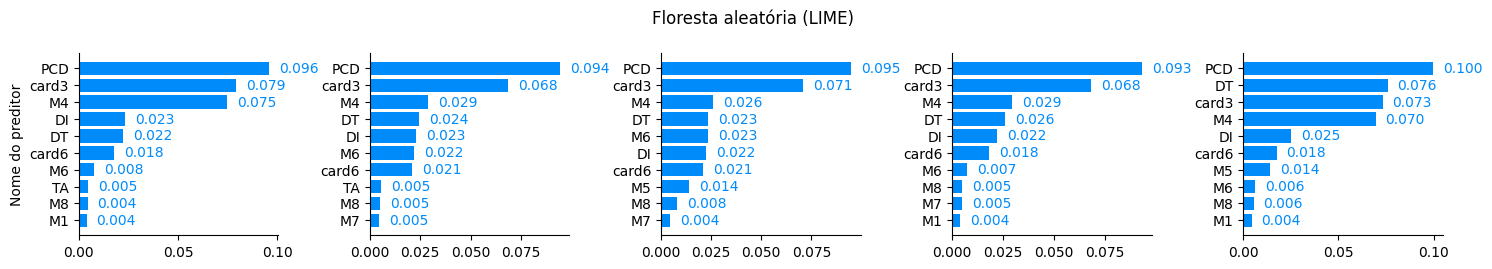

In [207]:
plot_lime_results_to_file(cross_random_fres, "Floresta aleatória (LIME)", "ieee_img/random_forest_feature_importance_plot(lime).pdf")

X does not have valid feature names, but LinearSVC was fitted with feature names
X does not have valid feature names, but LinearSVC was fitted with feature names
X does not have valid feature names, but LinearSVC was fitted with feature names
X does not have valid feature names, but LinearSVC was fitted with feature names
X does not have valid feature names, but LinearSVC was fitted with feature names


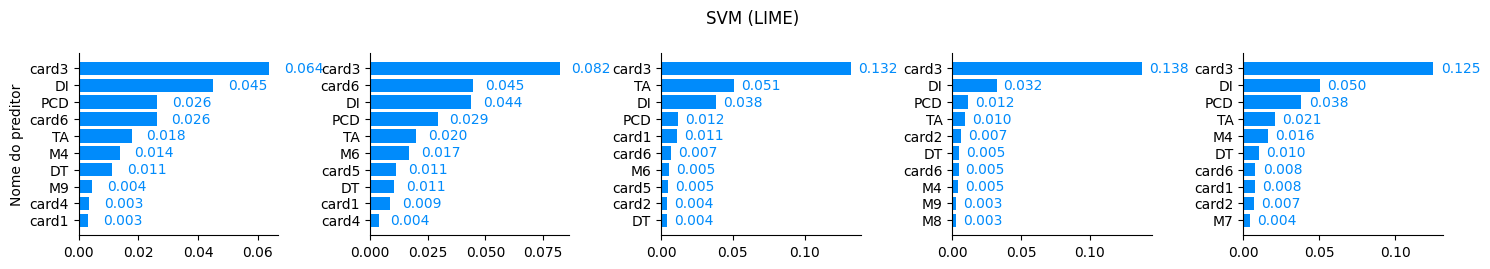

In [208]:
plot_lime_results_to_file_for_svm(cross_svm, "SVM (LIME)", "ieee_img/svm_feature_importance_plot(lime).pdf")

X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names


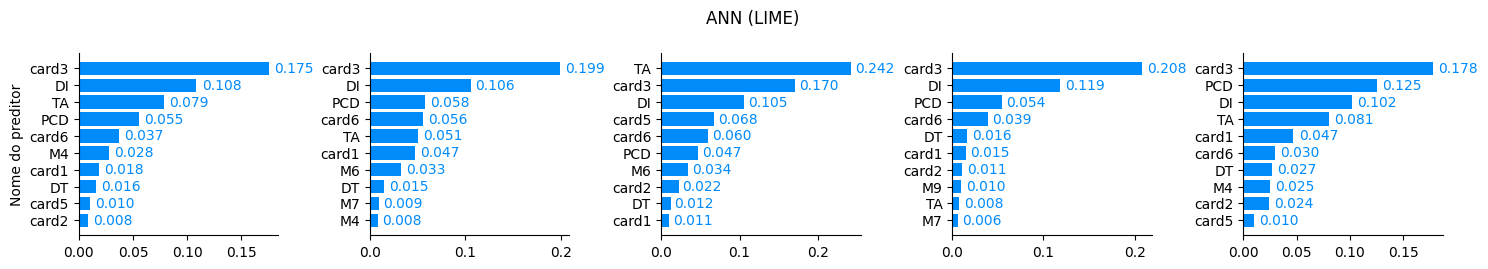

In [209]:
plot_lime_results_to_file(cross_ann, "ANN (LIME)", "ieee_img/ann_feature_importance_plot(lime).pdf")

# Calculando número de acertos e erros

In [210]:
def compute_agreement(data_dict):
    logistic_regression_values = data_dict['logistic_regression_values']
    num_agreements = {}
    for key in ['logistic_regression_lime', 'logistic_regression_shap', 'random_forest_lime', 'random_forest_shap', 'svm_lime', 'svm_shap', 'mlp_classifier_lime', 'mlp_classifier_shap', 'decision_tree_lime', 'decision_tree_shap']:
        num_agreements[key] = [sum([1 for s in data_dict[key][i] if s in logistic_regression_values[i]]) for i in range(len(logistic_regression_values))]
    return num_agreements


In [211]:
res = compute_agreement(data_dict)
print(res)

{'logistic_regression_lime': [7, 6, 7, 8, 7], 'logistic_regression_shap': [7, 7, 8, 7, 5], 'random_forest_lime': [6, 5, 7, 7, 7], 'random_forest_shap': [6, 6, 7, 5, 6], 'svm_lime': [4, 4, 4, 5, 4], 'svm_shap': [4, 3, 4, 3, 3], 'mlp_classifier_lime': [3, 4, 4, 5, 3], 'mlp_classifier_shap': [4, 3, 5, 3, 4], 'decision_tree_lime': [6, 4, 4, 4, 5], 'decision_tree_shap': [7, 7, 5, 7, 5]}
